# Conformalised ridge regression, and the least squares prediciton machine

In [1]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from online_cp import ConformalRidgeRegressor
from online_cp.CPS import RidgePredictionMachine
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Load data
We use the California Housing dataset, which is available through scikit-learn. It is quite large, so let's pick out a smaller set

In [2]:
housing = fetch_california_housing()

N = 300
data = housing.data
target = housing.target

X, X_other, Y, Y_other = train_test_split(data, target, train_size=N, random_state=42)

# p = 10
# rnd_gen = np.random.default_rng(2025)
# X = rnd_gen.normal(loc=0, scale=2, size=(N, p))

# coeff = rnd_gen.uniform(0, 1, size=p)
# Y = X @ coeff + rnd_gen.normal(loc=0, scale=1, size=N)

# Conformalised ridge regression
I was asked to show an online regression method, so here is the conformalised ridge regression (CRR) algorithm in practice. It is available in the python package online-cp.

The CRR algorithm is presented in Algorithm 2.4.

When constructing the object, there are some alternatives
* $a$ is the ridge parameter. By default it is 0, which corresponds to ordinary least squares.
* If `autotune` is set to `True`, the ridge parameter will be tuned by genearlised cross validation on the initial training set.
* If `studentised` is set to `True`, the nonconformity scores are scaled as discussed in Section 2.3.3, and the prediction sets are computed by Algorithm 2.5 (at least if $a=0$).

A very quick description of the algorithm for upper CRR, where the prediction set is a ray, follows.

Let $X_n = (x_1,x_2,\dots,x_n)^T$, and $Y_n = (y_1,y_2,\dots,y_n)^T$. The ridge regression predictions $\hat{y}_i$ for the objects $x_i$ are $\hat{Y}_n := X_n(X_n^TX_n + aI_p)^{-1}X_n^TY_n$, where the matrix $H_n:=X_n(X_n^TX_n + aI_p)^{-1}X_n^T$ is called the hat matrix. Recall that $I_m$ is the $m\times m$ identity matrix, and $a$ is the ridge parameter.

The nonconformity measure is the residuals, $y-\hat{y}$, so the vector of nonconformity scores is $Y_n - H_nY_n = (I_n - H_n)Y_n$. 

Suppose we know $x_1,y_1,\dots, x_{n-1},y_{n-1}, x_n$, but not $y_n$. For a hypothetical label $y$ for $x_n$, the vector of nonconformtiy scores can be written as $(I_n - H_n)Y^y = A + yB$, where $A = (I_n - H_n)(y_1,\dots,y_{n-1},0)^T$ and $B = (I_n - H_n)(0,\dots, 0, 1)^T$.

From $A$ and $B$, we can compute $t_i := \frac{a_i-a_n}{b_n - b_i}$ $i=1,\dots,n-1$, assuming $b_n>b_i$ (which holds almost surely under natural assumptions). The upper prediction set is then $(-\infty, t_{(k)}]$ for some index $k$, where $t_{(1)}\leq\dots\leq t_{(n-1)}$.

The p-value for $(x_n,y)$ is $p^y = \frac{|\{i=1,\dots,n-1:t_i\geq y\}| + 1}{n}$, which tells us that $k=\lceil(1-\varepsilon)n\rceil$ gives the prediction set at significance level $\varepsilon$. It is worth noting that we must have $\varepsilon \geq 1/n$ in order to get an informative prediction.

In [3]:
cp = ConformalRidgeRegressor(studentised=True)

epsilon = 0.1

# Ensure that we can get informative prediction sets
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = Y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = Y[int(np.ceil(2/epsilon)):]

cp.learn_initial_training_set(X_init_train, y_init_train)

Err = 0
Width = 0
res = np.zeros(shape=(y_process.shape[0], 2))

for i, (obj, lab) in tqdm(enumerate(zip(X_process, y_process)), desc='Processing dataset', total=y_process.shape[0]):
    
    # Make prediction
    Gamma, precomputed = cp.predict(obj, epsilon=0.1, return_update=True) 
    # To avoid repeating computations, we return some precomputed arrays if return_update=True

    # Check error
    Err += cp.err(Gamma, lab)

    # Learn the label
    cp.learn_one(obj, lab, precomputed)
    # We do not have to invert a matrix at each step n. The hat matrix can be efficiently updaten online using the Sherman-Morrison formula

    # Width of interval
    width = cp.width(Gamma)
    Width += width

    res[i, 0] = Err
    res[i, 1] = width

Processing dataset:   0%|          | 0/280 [00:00<?, ?it/s]

Error rate: 0.079
Average width: 2.651


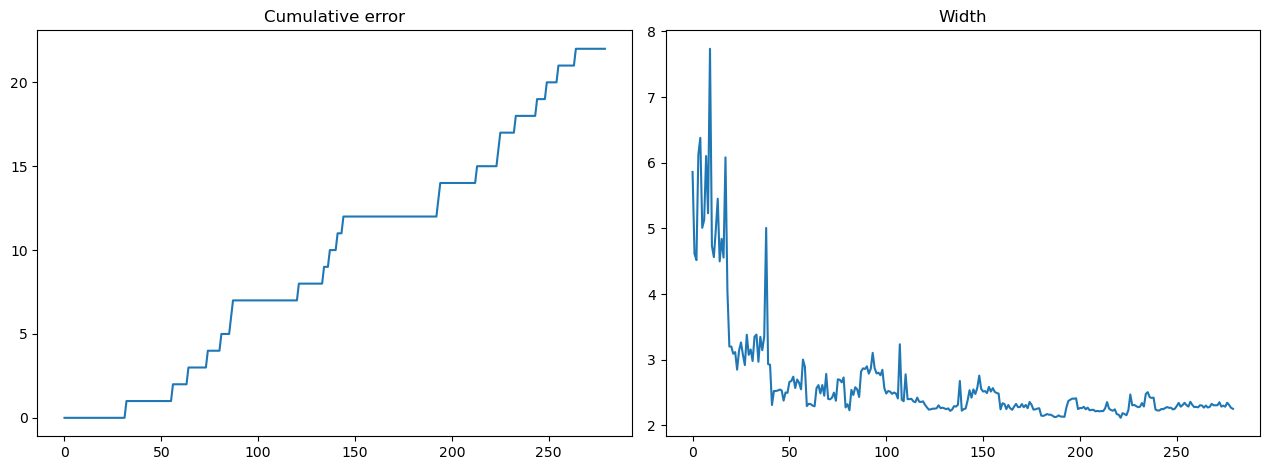

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(6.4 * 2, 4.8))
axs[0].plot(res[:, 0])
axs[0].set_title('Cumulative error')

axs[1].plot(res[:, 1])
axs[1].set_title('Width')
fig.tight_layout()

print(f'Error rate: {Err / y_process.shape[0]:.3f}')
print(f'Average width: {res[:, 1].mean():.3f}')

# Least squares prediction machine (LSPM)
We apply the LSPM on the same dataset.

In [5]:
cps = RidgePredictionMachine()

cps.learn_initial_training_set(X_init_train, y_init_train)

The `ConformalPredictiveSystem` object returns a `ConformalPredictiveDistribution` object, which is a callable object

In [6]:
cpd = cps.predict_cpd(X_process[0])

By default, it returns $\Pi_n(y, 0)$ and $\Pi_n(y,1)$

In [7]:
cpd(1)

(0.23809523809523808, 0.2857142857142857)

If a random number $\tau_n$ is passed, it returns the convex combination $(1-\tau_n)\Pi_n(y, 0) + \tau_n\Pi_n(y,1)$

In [8]:
tau = rnd_gen.uniform(0, 1)
cpd(1, tau)

0.2702776827610134

We can plot the CPD, to see the whole predictive distribution

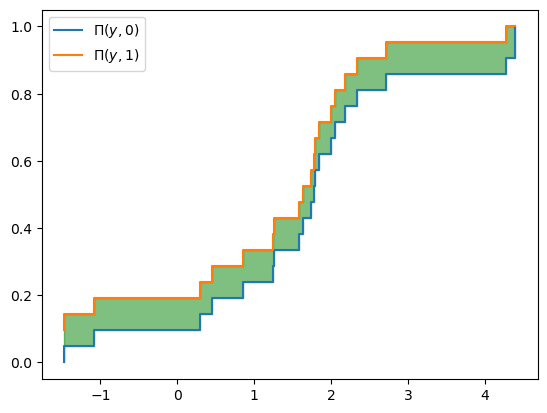

In [9]:
cpd.plot()

We can also compute any quantile (with or without $\tau_n$)

In [10]:
cpd.quantile(0.8, tau)

2.3316608462843034

And we can use the CPD to construct a prediciton set at any significance level

In [11]:
cpd.predict_set(epsilon=epsilon, tau=tau, minimise_width=True)

(-1.467632431720552, 4.391954342189416)

Say we are interested in producing prediction sets at a significance level $\varepsilon$. Typically, one would choose the $\varepsilon/2$ and the $1-\varepsilon/2$ quantiles. However, we may pick any two quantiles $\varepsilon_L$ and $\varepsilon_U$ such that $\varepsilon_L+\varepsilon_U=\varepsilon$. Having computed the CPD, we may pick the smallest interval at a given significance level. 

In [12]:
cps = RidgePredictionMachine()

cps.learn_initial_training_set(X_init_train, y_init_train)

Err = 0
Width = 0
Err_opt = 0
Width_opt = 0
res = np.zeros(shape=(y_process.shape[0], 5))

for i, (obj, lab) in tqdm(enumerate(zip(X_process, y_process)), desc='Processing dataset', total=y_process.shape[0]):
    tau = np.random.uniform(0, 1)
    
    # Compute CPD
    cpd, precomputed = cps.predict_cpd(obj, return_update=True) 
    # To avoid repeating computations, we return some precomputed arrays if return_update=True

    Gamma = cpd.predict_set(tau=tau, epsilon=epsilon)
    Gamma_opt = cpd.predict_set(tau=tau, epsilon=epsilon, minimise_width=True)

    # Check error
    Err += cpd.err(Gamma, lab)
    Err_opt += cpd.err(Gamma_opt, lab)

    # Learn the label
    cps.learn_one(obj, lab, precomputed)
    # We do not have to invert a matrix at each step n. The hat matrix can be efficiently updaten online using the Sherman-Morrison formula

    # Width of interval
    width = cpd.width(Gamma)
    width_opt = cpd.width(Gamma_opt)
    Width += width
    Width_opt += width_opt

    # Compute p-value
    p = cpd(lab, tau)

    res[i, 0] = Err
    res[i, 1] = width
    res[i, 2] = Err_opt
    res[i, 3] = width_opt
    res[i, 4] = p

Processing dataset:   0%|          | 0/280 [00:00<?, ?it/s]

Error rate basic: 0.082
Error rate optimised: 0.104
Average width basic: 2.520
Average width optimised: 2.416


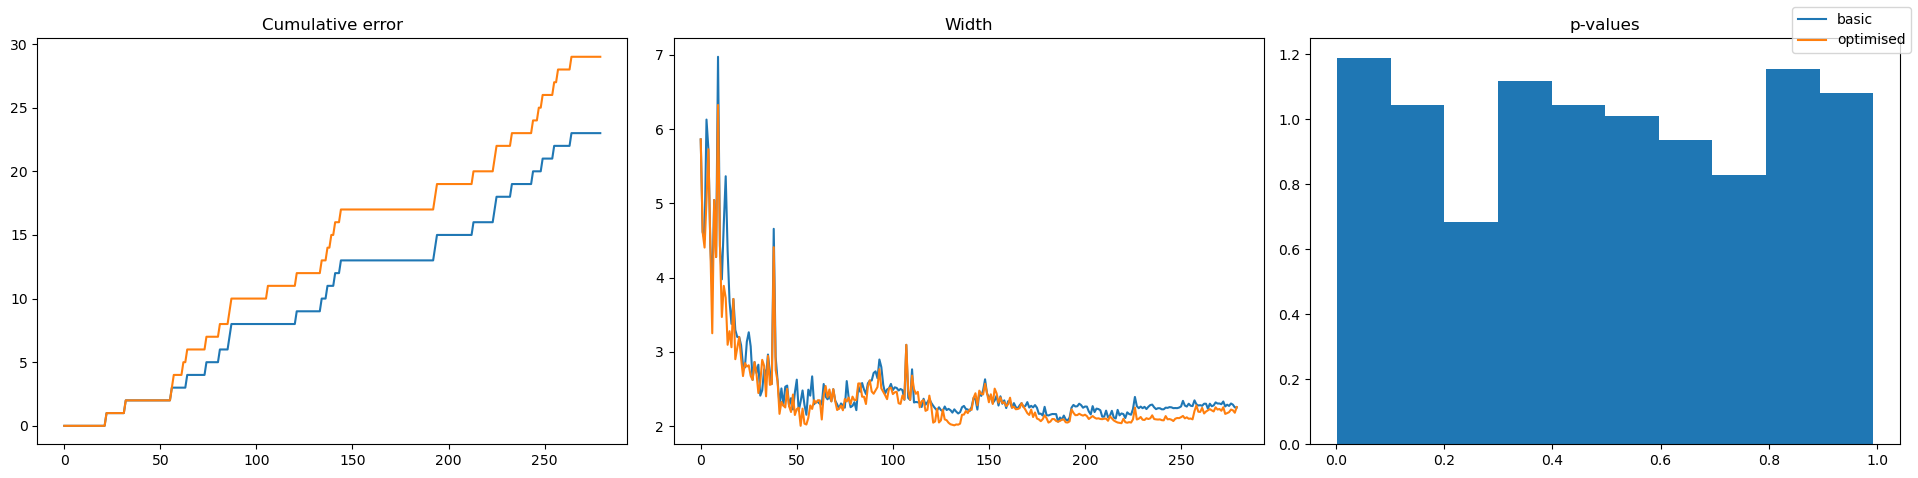

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(6.4 * 3, 4.8))
axs[0].plot(res[:, 0], label='basic')
axs[0].plot(res[:, 2], label='optimised')
axs[0].set_title('Cumulative error')

axs[1].plot(res[:, 1])
axs[1].plot(res[:, 3])
axs[1].set_title('Width')

axs[2].hist(res[:,4], density=True)
axs[2].set_title('p-values')
fig.legend()
fig.tight_layout()
print(f'Error rate basic: {Err/y_process.shape[0]:.3f}')
print(f'Error rate optimised: {Err_opt/y_process.shape[0]:.3f}')
print(f'Average width basic: {res[:, 1].mean():.3f}')
print(f'Average width optimised: {res[:, 3].mean():.3f}')

As an illustration, we plot the last CPD, and visualise the prediction sets.

Width CP: 2.253
Width CPD: 2.259


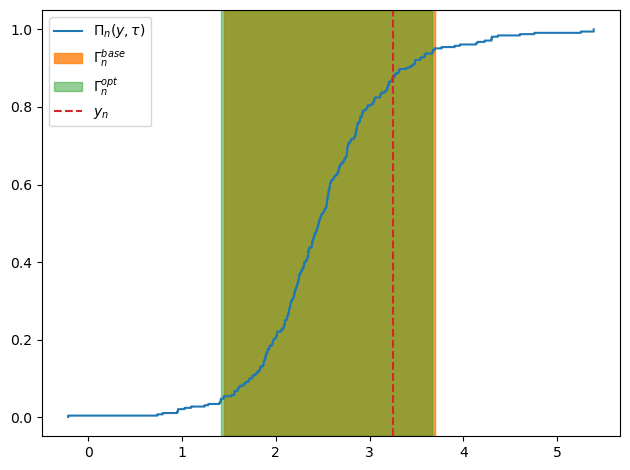

In [14]:
fig, ax = plt.subplots()

ax.step(cpd.y_vals, (1 - tau) * cpd.lowers + tau * cpd.uppers, label=r'$\Pi_n(y, \tau)$')

# Standard conformal set
ax.axvspan(Gamma[0], Gamma[1], color='C1', label=r'$\Gamma_n^{base}$', alpha=0.8)

# Minimal prediction set
Gamma_min = Gamma_opt
ax.axvspan(Gamma_min[0], Gamma_min[1], color='C2', label=r'$\Gamma_n^{opt}$', alpha=0.5)

# Truth
ax.axvline(Y[-1], color='C3', linestyle='--', label=r'$y_n$')

ax.legend()
fig.tight_layout()
print(f'Width CP: {cpd.width(Gamma):.3f}')
print(f'Width CPD: {cpd.width(Gamma_min):.3f}')

Text(0.5, 1.0, 'CRPS integrand')

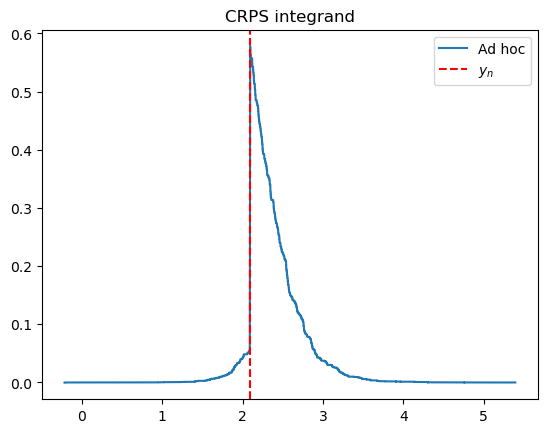

In [47]:
lab = y_process[0]
func0 = lambda x: (cpd(x, 0) - int(lab <= x))**2
func1 = lambda x: (cpd(x, 1) - int(lab <= x))**2
func_tau = lambda x: (cpd(x, 0.5) - int(lab <= x))**2

func_ad_hoc = lambda x: (cpd(x, 0) - int(lab <= x))**2 if x <= lab else (cpd(x, 1) - int(lab <= x))**2

xrange = cpd.y_vals.copy()# np.linspace(-10, 10, endpoint=True, num=1000)

# plt.plot(
#     xrange, 
#     [func0(x) for x in xrange],
#     label='0'
# )
# plt.plot(
#     xrange, 
#     [func1(x) for x in xrange],
#     label='1'
# )
# plt.plot(
#     xrange, 
#     [func_tau(x) for x in xrange],
#     label=r'$\tau$'
# )
plt.plot(
    xrange, 
    [func_ad_hoc(x) for x in xrange],
    label='Ad hoc'
)
plt.axvline(lab, linestyle='--', color='red', label=r'$y_n$')
plt.legend()
plt.title('CRPS integrand')

In [51]:
np.trapz([func_ad_hoc(x) for x in cpd.y_vals[1:-1]], cpd.y_vals[1:-1])

0.231946181796286

In [46]:
xrange = np.linspace(-100, 100, num=100000)
np.trapz([func_ad_hoc(x) for x in xrange[1:-1]], xrange[1:-1])

# [func_ad_hoc(x) for x in xrange[1:-1]]

0.2333738448495571

In [16]:
# Step 1: Compute the widths of the intervals
widths = np.diff(cpd.y_vals[1:-1])

# Step 2: Compute the areas of each interval
vals = np.array([func_ad_hoc(x) for x in cpd.y_vals[1:-1]])
areas = widths * vals[:-1]

# Step 3: Sum the areas to compute the integral
integral = np.sum(areas)
integral

0.23046660997165946

In [17]:
tau = rnd_gen.uniform(0, 1)
Epsilon = np.linspace(0, 1, endpoint=True, num=1000)
widths = np.zeros_like(Epsilon)
for i, epsilon in enumerate(Epsilon):
    widths[i] = cpd.width(cpd.predict_set(tau=tau, epsilon=epsilon, minimise_width=True))

/home/johan/miniconda3/envs/onlineCP/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2318: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/home/johan/miniconda3/envs/onlineCP/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2319: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/home/johan/miniconda3/envs/onlineCP/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2319: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/CPS.py:548: RuntimeWarning: invalid value encountered in scalar subtract
  return self.quantile(1-epsilon_minus_delta, tau) - self.quantile(delta, tau)


In [18]:
finite = np.where(widths < np.inf)[0]
np.trapz(widths[finite], Epsilon[finite])

0.9987682888447386

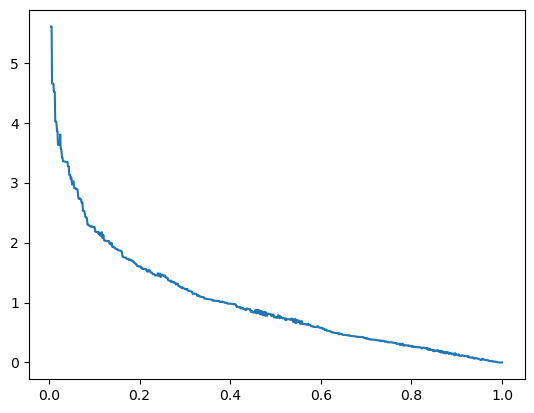

In [19]:
plt.plot(Epsilon, widths)